In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

In [2]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

In [24]:
def mod_df(df, ix, c):
    arr_count = np.stack(df.loc[ix, 'onehot_count'])
    arr_count[:, c] = 0
    series_count = pd.Series(list(arr_count), index=ix)  # convert to series of arrays
    
    arr_area = np.stack(df.loc[ix, 'onehot_area'])
    arr_area[:, c] = 0
    series_area = pd.Series(list(arr_area), index=ix)  # convert to series of arrays
    
    arr_length = np.stack(df.loc[ix, 'onehot_length'])
    arr_length[:, c] = 0
    series_length = pd.Series(list(arr_length), index=ix)  # convert to series of arrays

    df.loc[ix, 'onehot_count'] = series_count
    df.loc[ix, 'onehot_area'] = series_area
    df.loc[ix, 'onehot_length'] = series_length

# Train on all OSM classes (emb v1)

In [5]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
# conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v0.2-20240426"
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0/"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-10 13:03:41.522 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-10 13:03:44.858 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 58598 chip files (out of 58690)
2024-05-10 13:03:44.858 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-10 13:03:45.229 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-10 13:03:45.898 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read val split with 11822 chip files (out of 11841)
2024-05-10 13:03:45.898 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-10 13:03:4

In [6]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

In [7]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.15306 params 0.0380735
epoch   1 step 3662 loss 0.15394 params 0.0622502
epoch   2 step 3662 loss 0.14567 params 0.0932073
epoch   3 step 3662 loss 0.12993 params 0.1252400
epoch   4 step 3662 loss 0.13528 params 0.1573482
epoch   5 step 3662 loss 0.12852 params 0.1897411
epoch   6 step 3662 loss 0.13352 params 0.2223516
epoch   7 step 3662 loss 0.12709 params 0.2550223
epoch   8 step 3662 loss 0.12956 params 0.2875034
epoch   9 step 3662 loss 0.13169 params 0.3198225
epoch  10 step 3662 loss 0.12964 params 0.3522349
epoch  11 step 3662 loss 0.13013 params 0.3845709
epoch  12 step 3662 loss 0.12330 params 0.4167915
epoch  13 step 3662 loss 0.12224 params 0.4489191
epoch  14 step 3662 loss 0.12521 params 0.4811122
epoch  15 step 3662 loss 0.12327 params 0.5132212
epoch  16 step 3662 loss 0.12320 params 0.5452713
epoch  17 step 3662 loss 0.12094 params 0.5770732
epoch  18 step 3662 loss 0.12712 params 0.6088907
epoch  19 step 3662 loss 0.12052 params 0.6404727


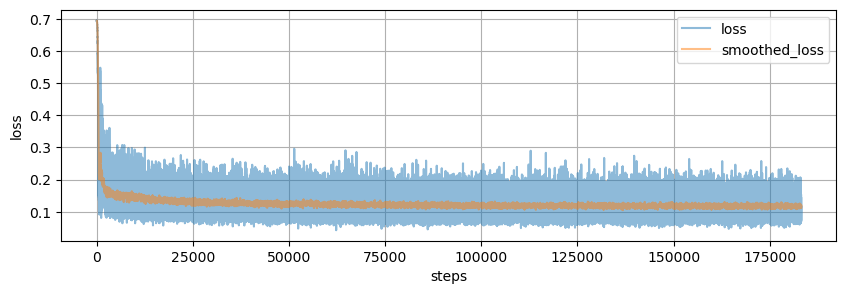

In [8]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [9]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:12 Time:  0:00:120001


((58598, 99), (58598, 99))

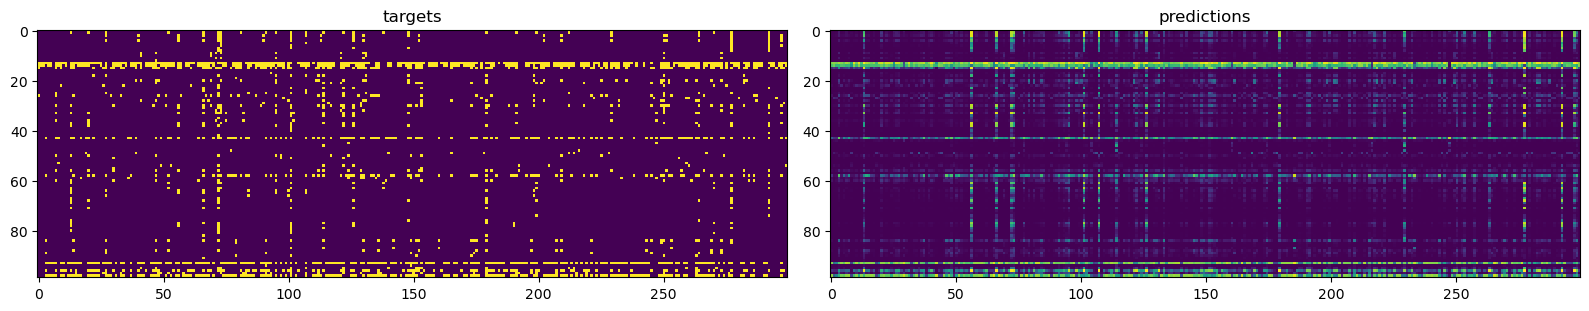

In [10]:
idxs = np.random.permutation(len(targets))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [11]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5722176100014651, 'prec': 0.7450246067372865}

In [12]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)

(0.7450246067372865, 0.5722176100014651)

In [13]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

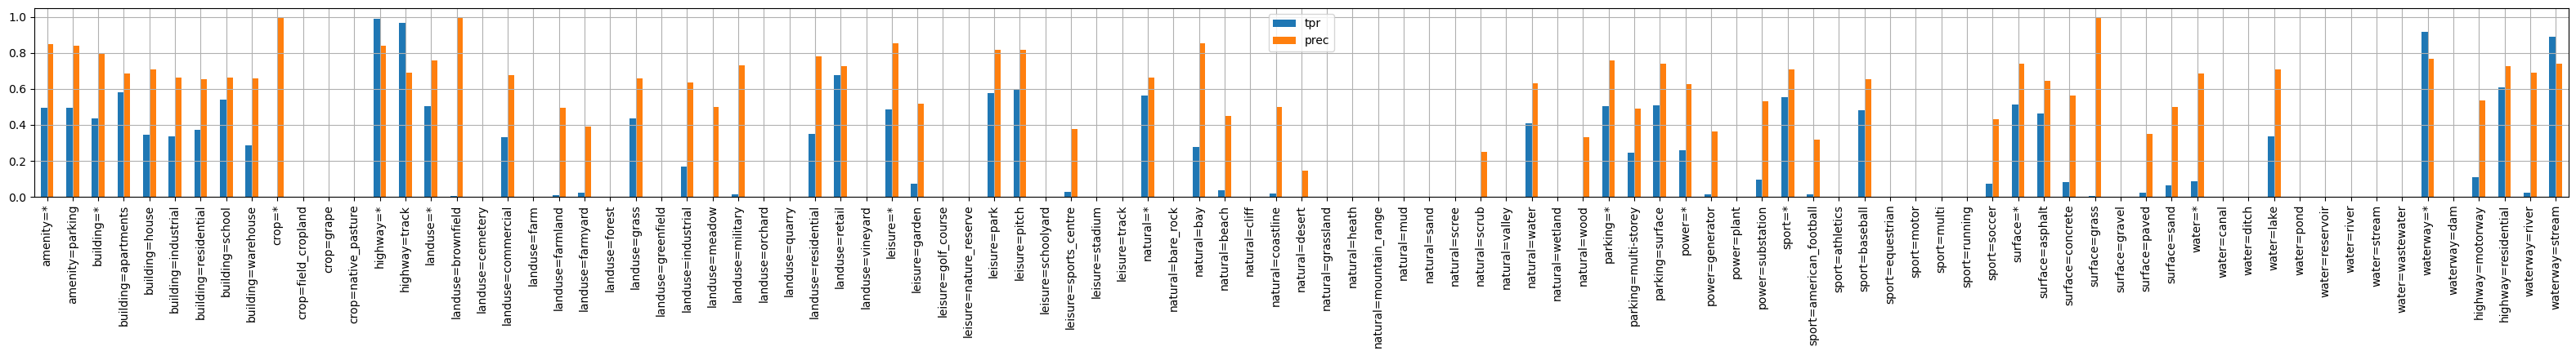

In [14]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()
ax.set_xticklabels(labels=(name_dict[i] for i in range(99)), rotation=90, fontsize=10);

In [15]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:01:47 Time:  0:01:470109


(100, 99, 2)

Classes to retain based on the below

In [36]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 58, 61, 68, 71, 84,
                  87, 93, 95, 96, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

25
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


<Figure size 640x480 with 0 Axes>

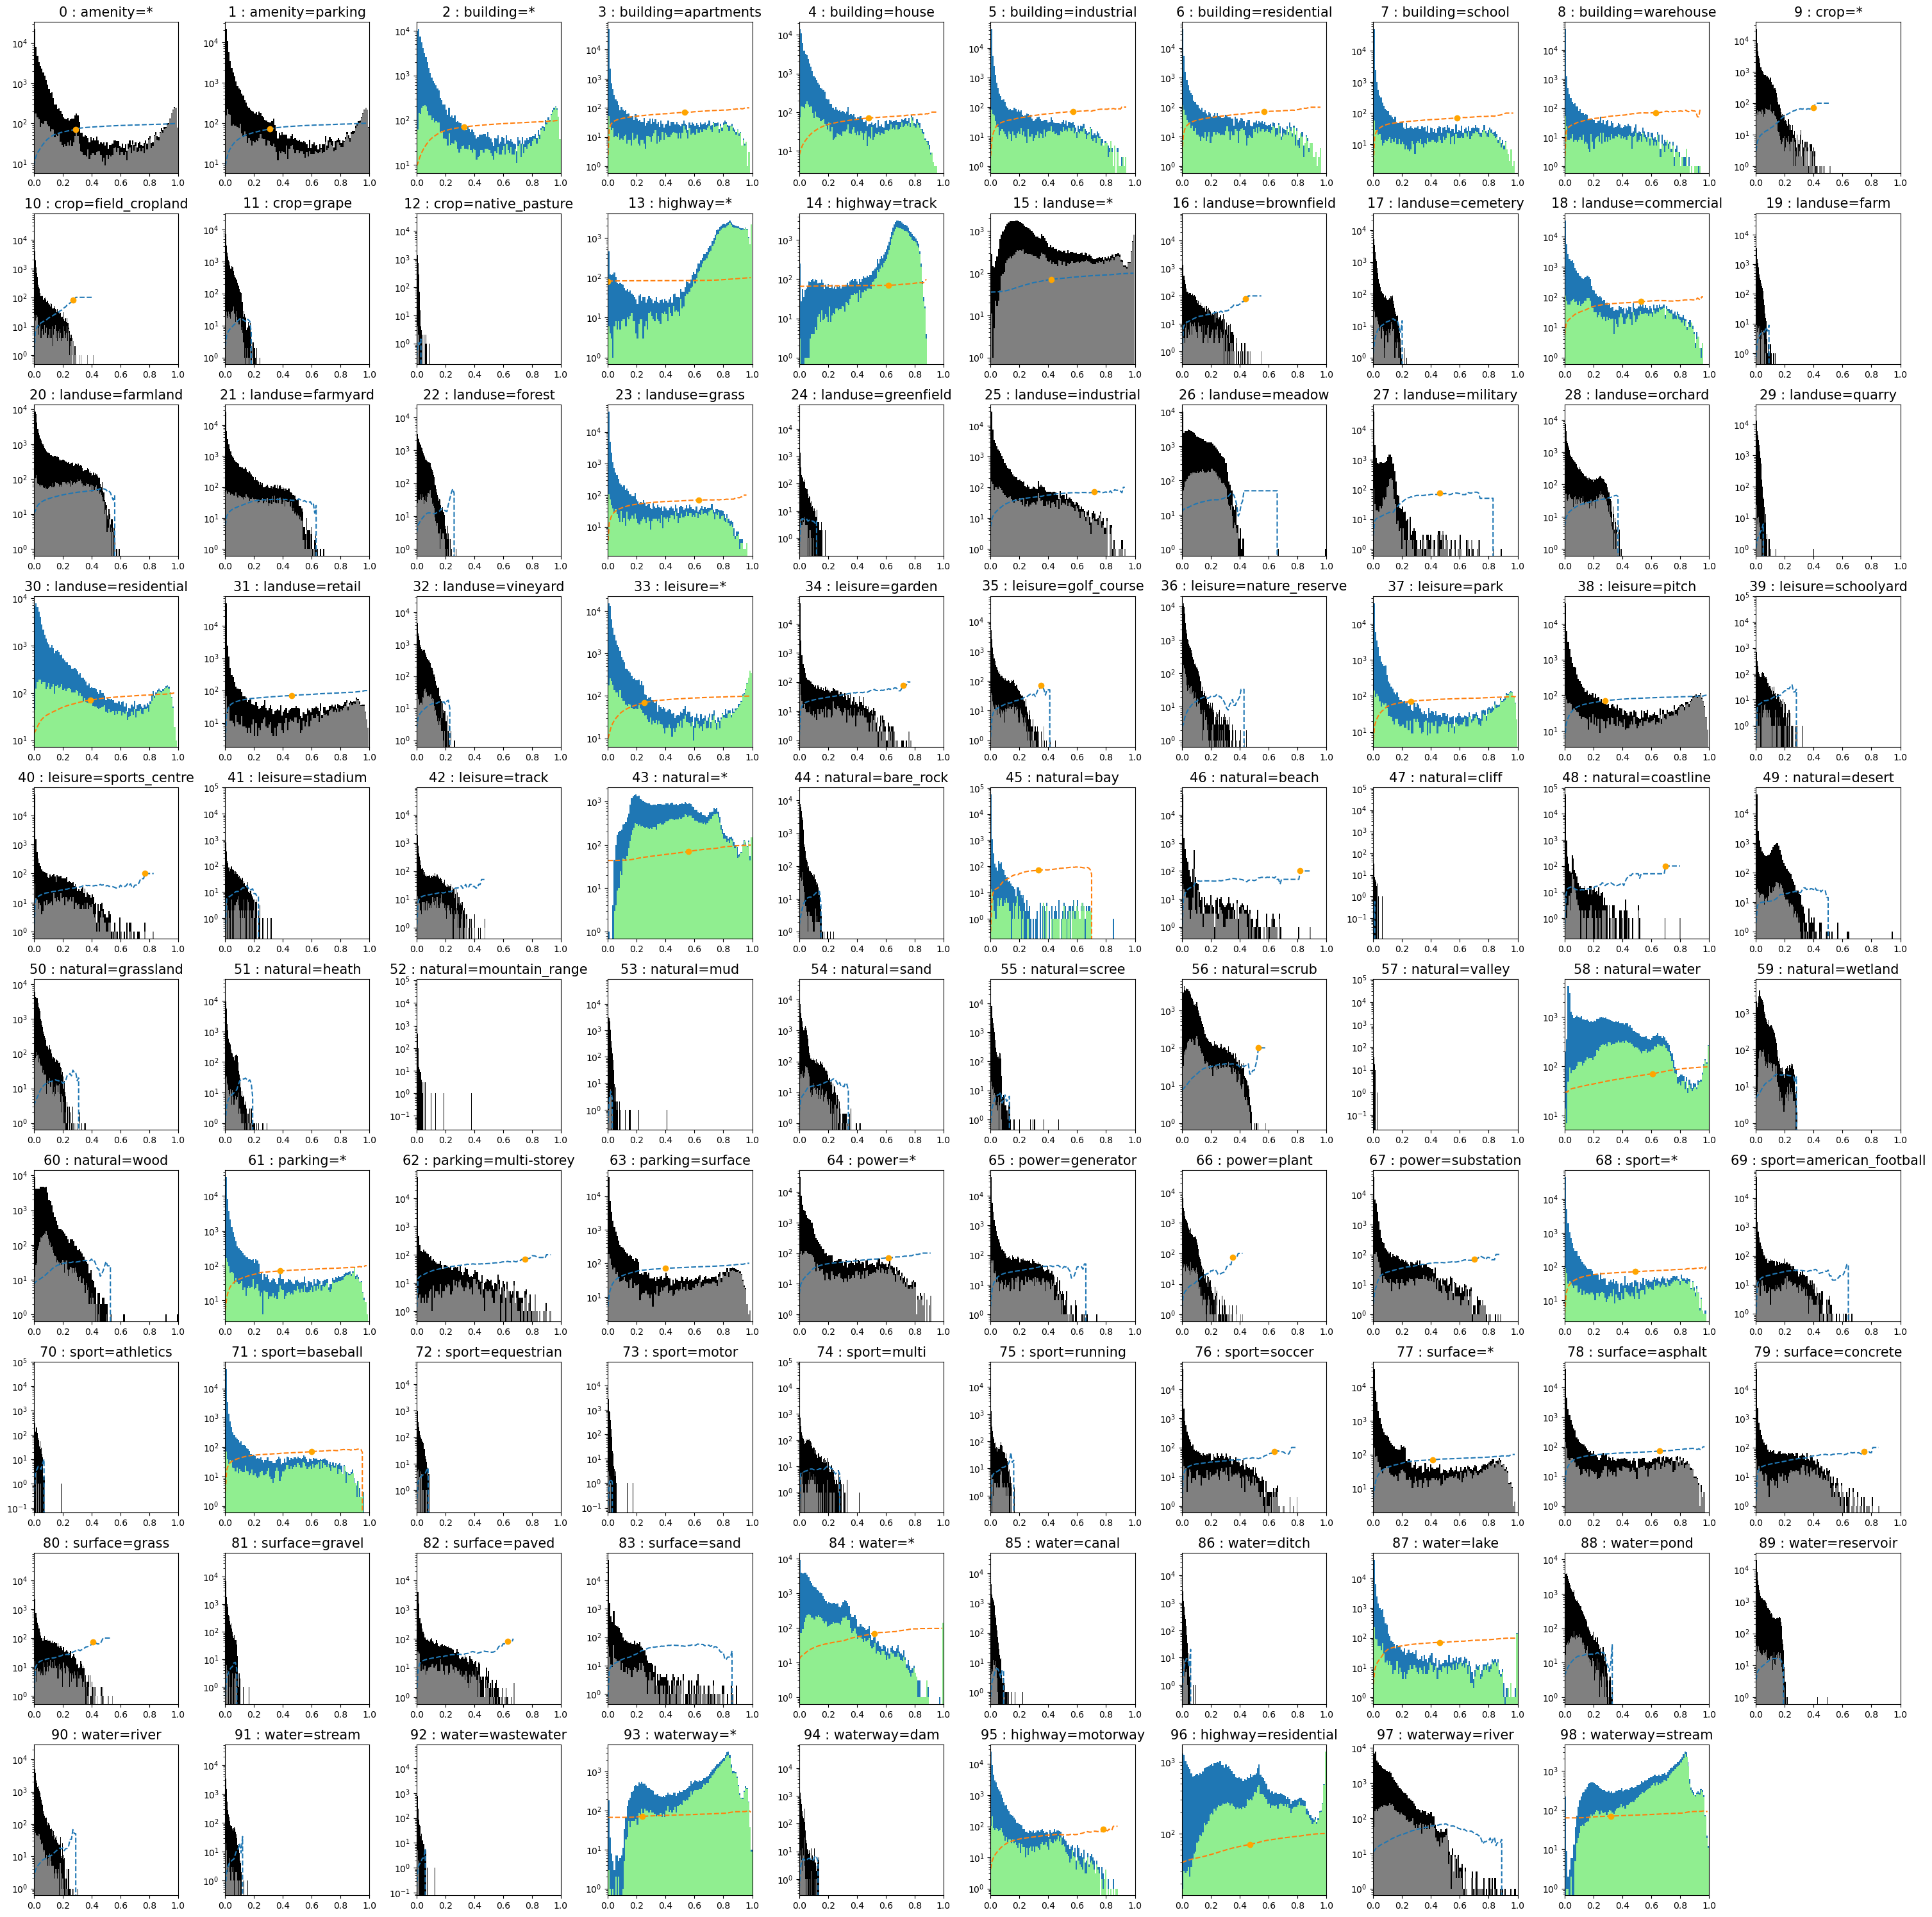

In [22]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

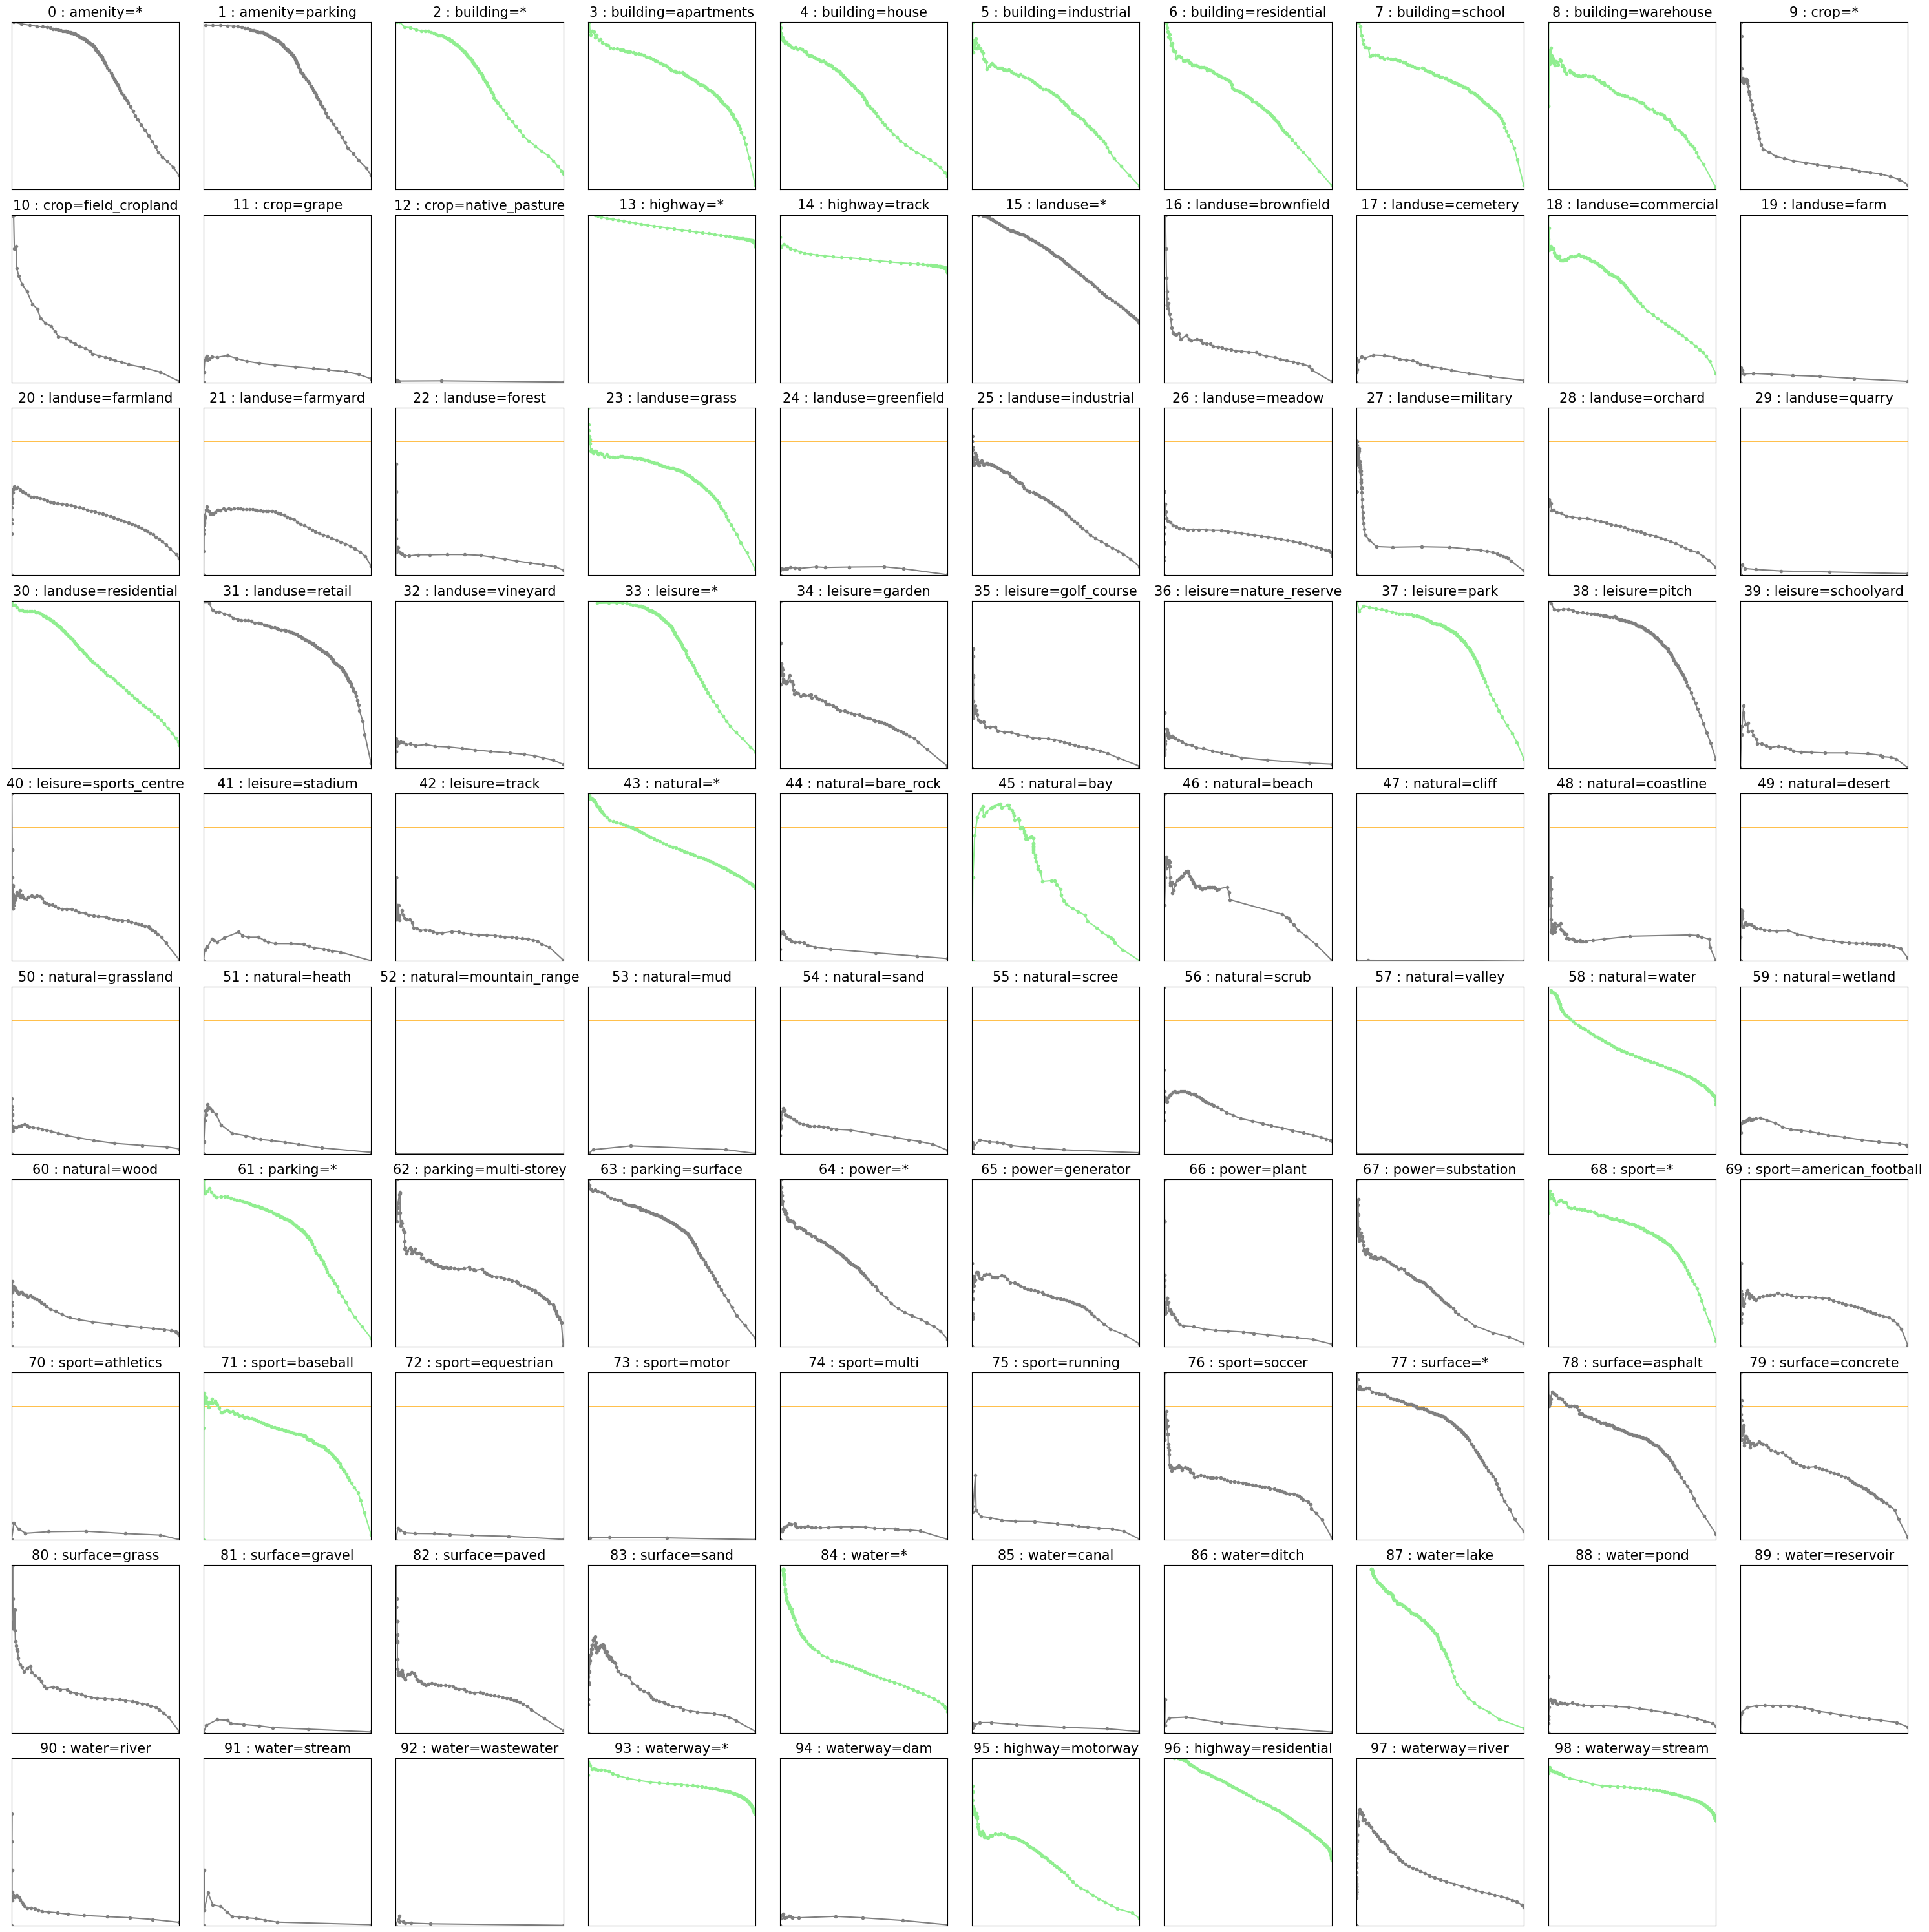

In [23]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();

Cut-off probabilities

In [25]:
prob_cutoff = {}
for c in classes_retain:
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for c in prob_cutoff:
    i_alter = (predictions[:, c] < prob_cutoff[c])
    targets2[i_alter, c] = 0

26
{2: 0.33, 3: 0.53, 4: 0.48, 5: 0.57, 6: 0.57, 7: 0.58, 8: 0.63, 13: 0.0, 14: 0.62, 18: 0.53, 23: 0.63, 30: 0.39, 33: 0.25, 37: 0.26, 43: 0.56, 45: 0.33, 58: 0.61, 61: 0.38, 68: 0.49, 71: 0.6, 84: 0.52, 87: 0.46, 93: 0.24, 95: 0.78, 96: 0.47, 98: 0.32}


# Train on retained OSM classes (emb v1)

In [39]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 45, 58, 61, 68, 71,
                  84, 87, 93, 95, 96, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

26
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


In [27]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0/"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-10 13:52:49.554 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-10 13:52:52.924 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 58598 chip files (out of 58690)
2024-05-10 13:52:52.925 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-10 13:52:53.614 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-10 13:52:54.290 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read val split with 11822 chip files (out of 11841)
2024-05-10 13:52:54.291 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-10 13:52:5

In [28]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

561306

---

In [29]:
n_epochs = 100

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.27530 params 0.0375919
epoch   1 step 3662 loss 0.27995 params 0.0618761
epoch   2 step 3662 loss 0.26950 params 0.0914849
epoch   3 step 3662 loss 0.23892 params 0.1226464
epoch   4 step 3662 loss 0.24880 params 0.1543741
epoch   5 step 3662 loss 0.24712 params 0.1863066
epoch   6 step 3662 loss 0.24432 params 0.2179694
epoch   7 step 3662 loss 0.23704 params 0.2496636
epoch   8 step 3662 loss 0.23240 params 0.2813675
epoch   9 step 3662 loss 0.23480 params 0.3129408
epoch  10 step 3662 loss 0.22235 params 0.3443599
epoch  11 step 3662 loss 0.22114 params 0.3756443
epoch  12 step 3662 loss 0.23832 params 0.4070037
epoch  13 step 3662 loss 0.22817 params 0.4382184
epoch  14 step 3662 loss 0.22786 params 0.4696088
epoch  15 step 3662 loss 0.23242 params 0.5006019
epoch  16 step 3662 loss 0.22421 params 0.5316740
epoch  17 step 3662 loss 0.22845 params 0.5628881
epoch  18 step 3662 loss 0.21584 params 0.5942324
epoch  19 step 3662 loss 0.22375 params 0.6252333


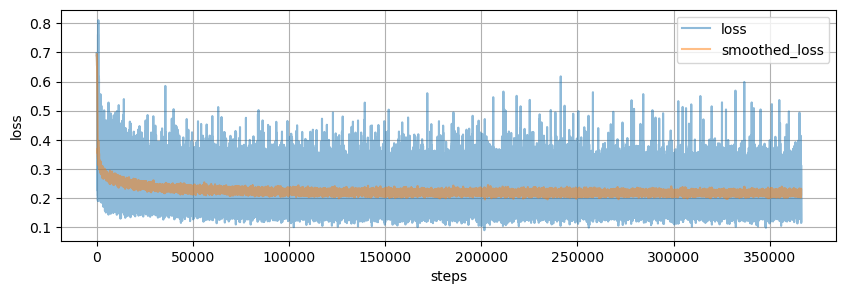

In [30]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [31]:
targets_train = []
predictions_train = []
embeddings_train = []
chip_IDs_train = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)

    for xi in x.detach().numpy():
        embeddings_train.append(xi)
    
    for ti in t.detach().numpy():
        targets_train.append(ti)

    for oi in o.detach().numpy():
        predictions_train.append(oi)

    chip_IDs_train.extend(cid)  # +=

embeddings_train = np.r_[embeddings_train]
targets_train = np.r_[targets_train]
predictions_train = np.r_[predictions_train]
chip_IDs_train = np.r_[chip_IDs_train]
embeddings_train.shape, targets_train.shape, predictions_train.shape, chip_IDs_train.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:15 Time:  0:00:150001


((58598, 768), (58598, 26), (58598, 26), (58598,))

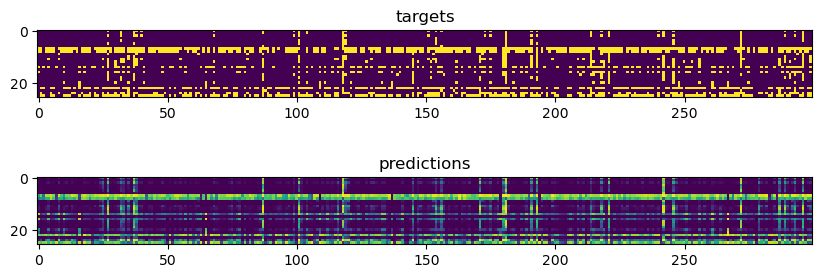

In [32]:
idxs = np.random.permutation(len(targets_train))[:300]

fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets_train[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions_train[idxs].T, interpolation='none');
ax[1].set_title("predictions");

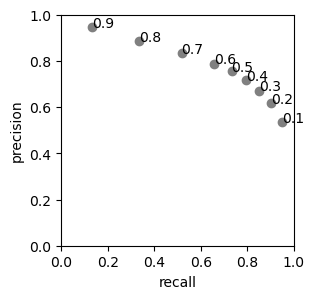

In [33]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets_train.flatten(), predictions_train.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [34]:
R_train = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_train[:,c], predictions_train[:,c] >= thres) for c in range(targets_train.shape[-1])]
    r = pd.DataFrame(r)
    R_train.append(r)

R_train = np.array([r.values for r in R_train])
R_train.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:340003


(100, 26, 2)

<Figure size 640x480 with 0 Axes>

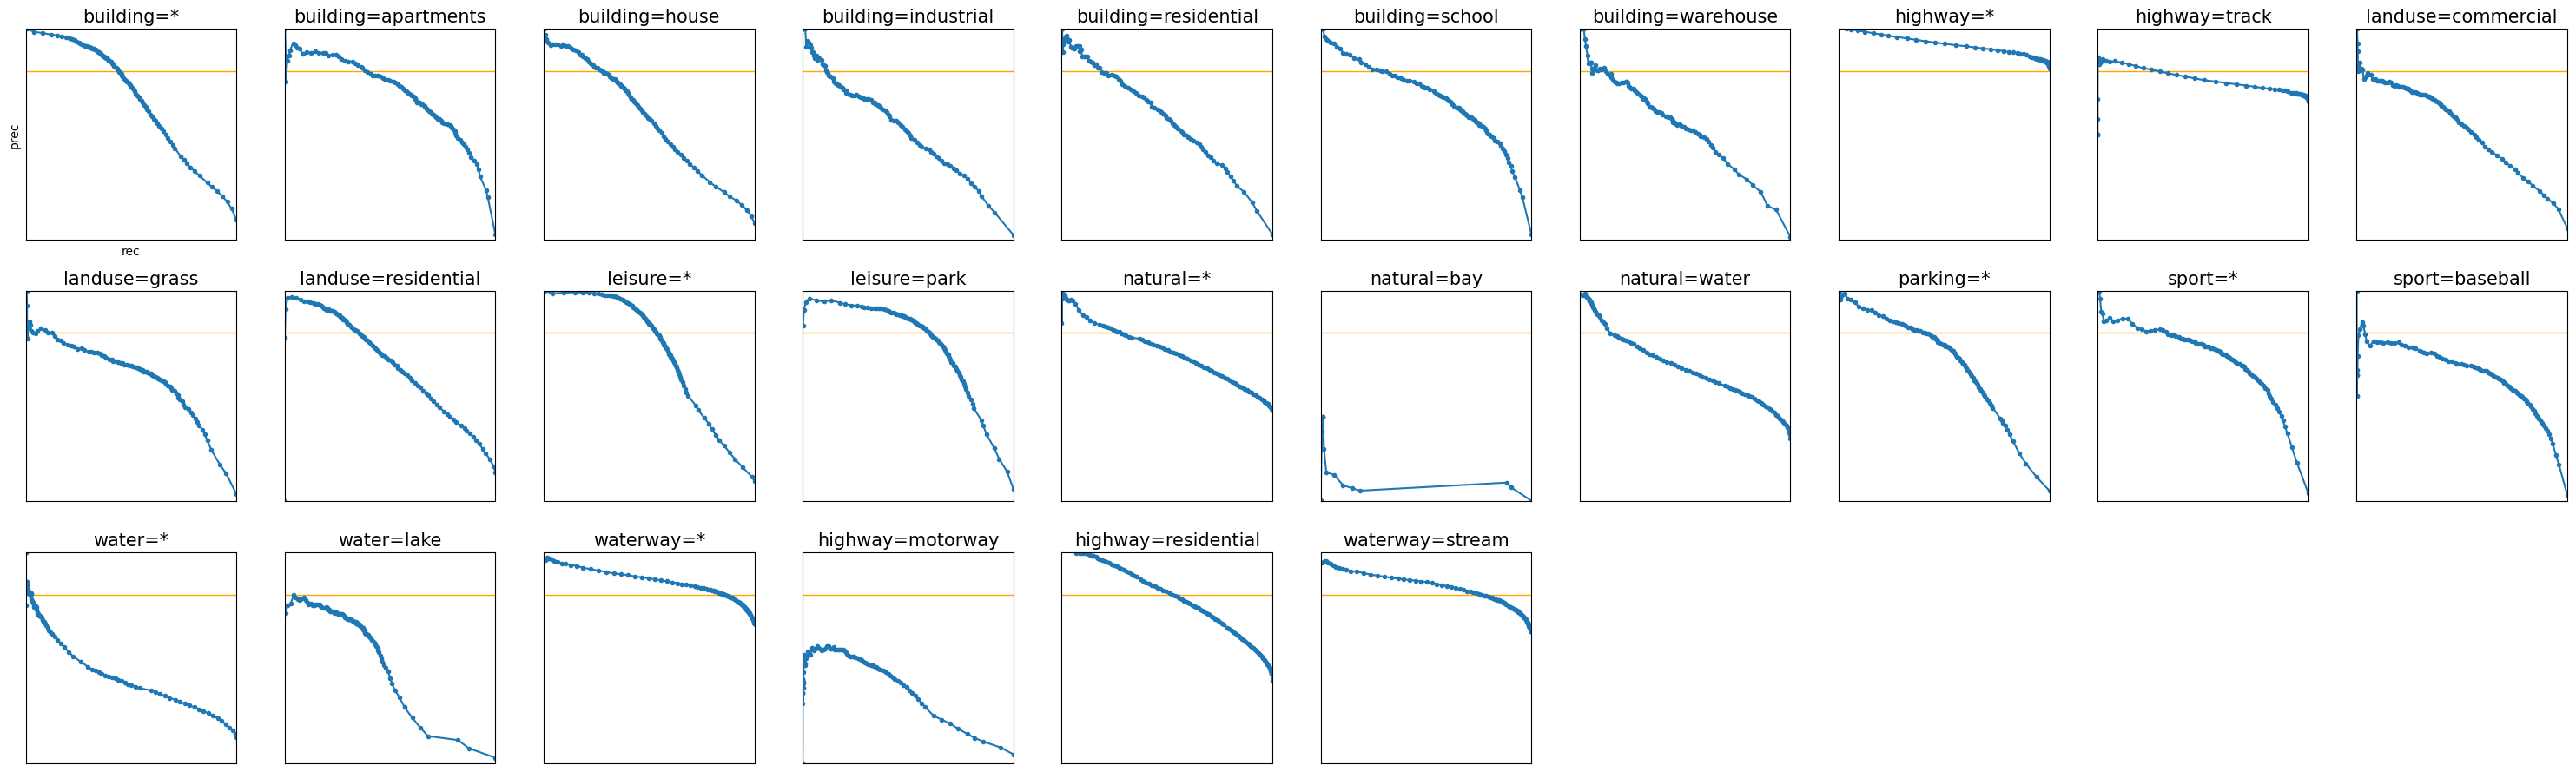

In [40]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=1, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R_train[:, c, :].T, marker='o', ls='-', markersize=3);
    # for i, thres in enumerate(np.linspace(0.1, 1, 10)):
    #     if None not in R_train[i, c, :] and np.isfinite(list(R_train[i, c, :])).all():
    #         ax.text(*R_train[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

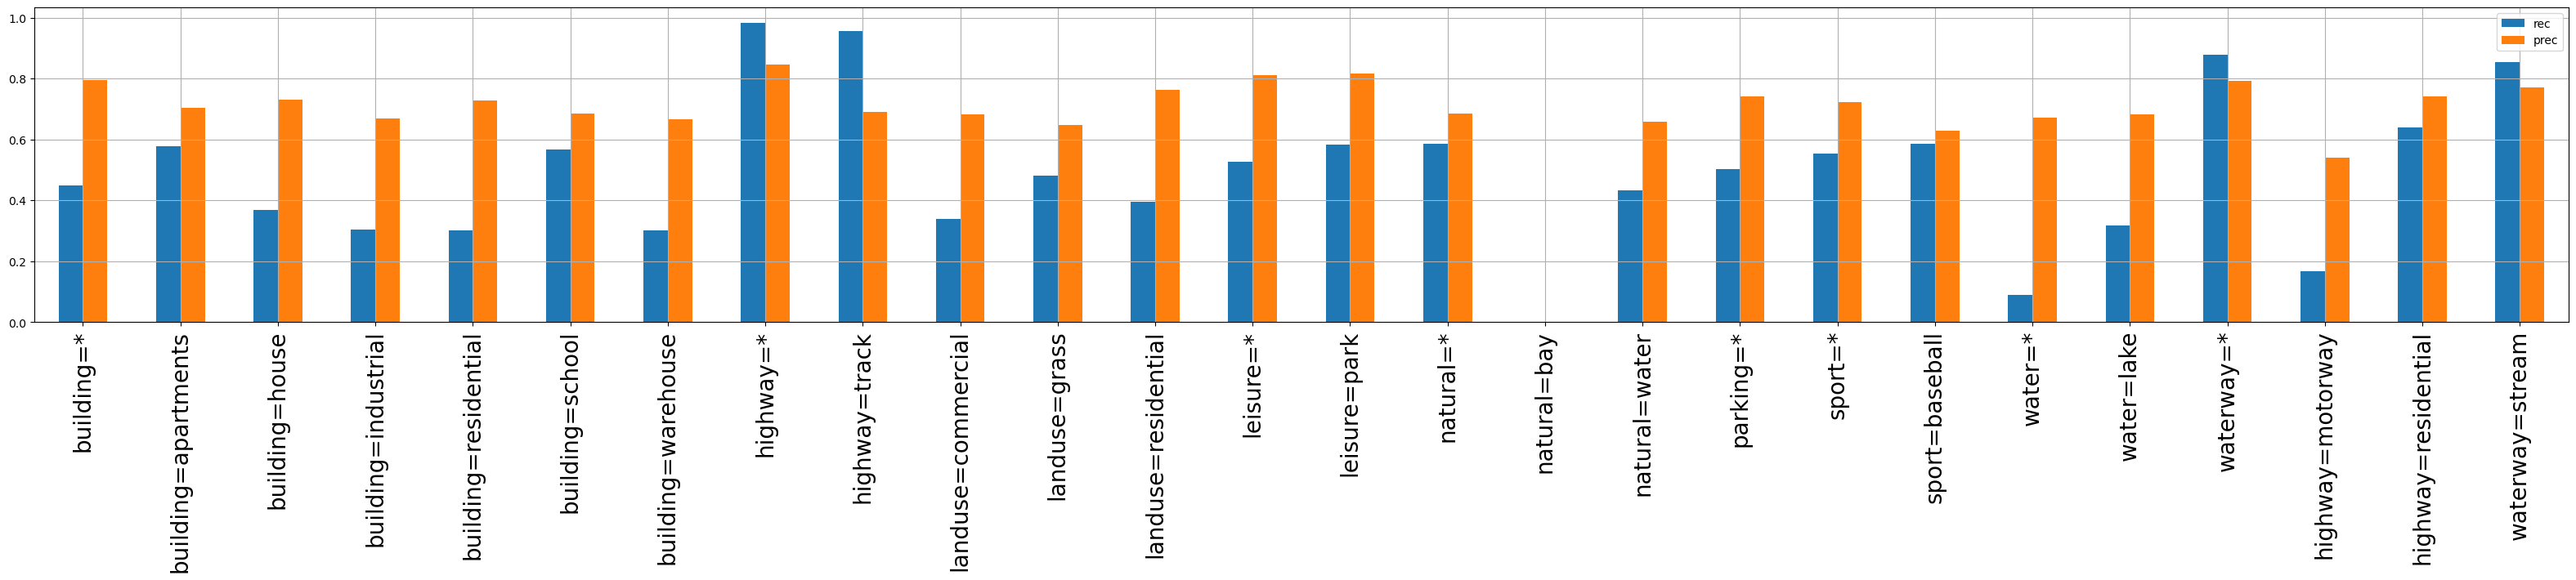

In [41]:
ax = pd.DataFrame(R_train[50], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[classes_retain[i]] for i in range(len(classes_retain))), rotation=90, fontsize=20);

<Figure size 640x480 with 0 Axes>

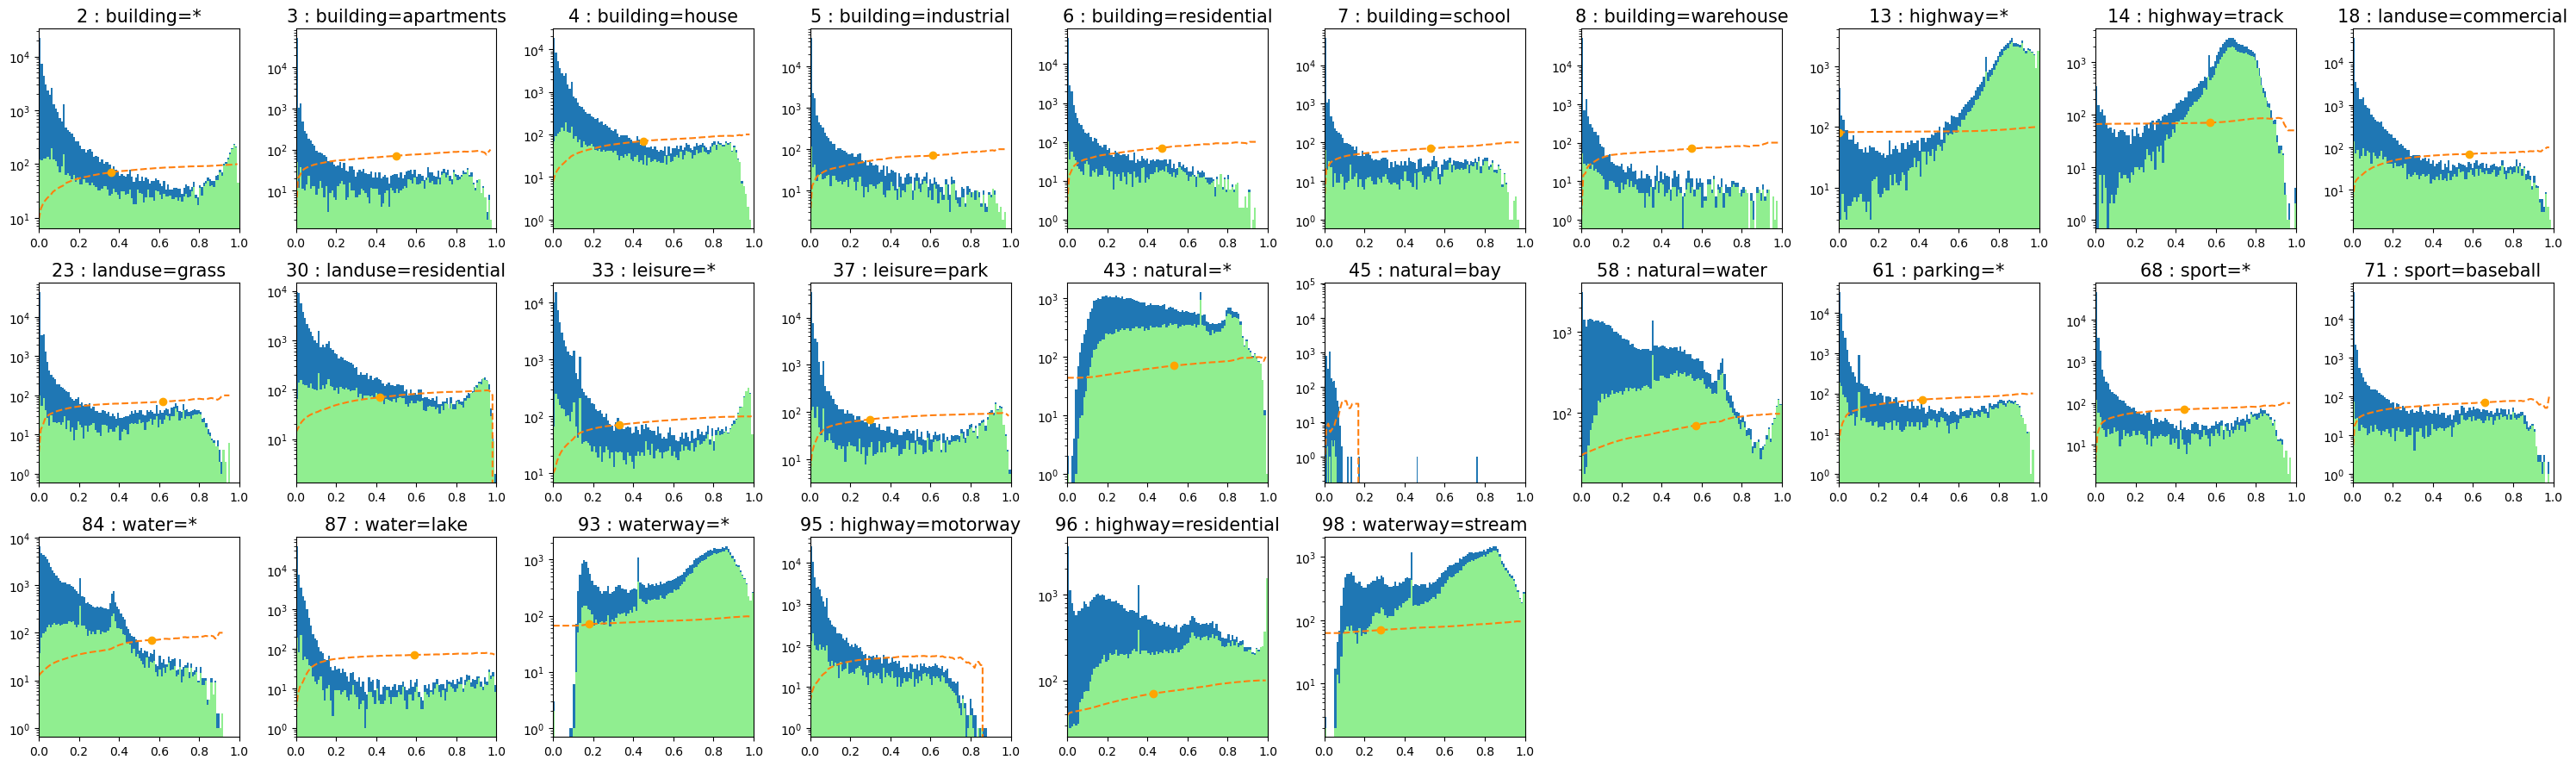

In [42]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions_train[:, c], bins=100);
    plt.hist(predictions_train[targets_train[:, c] > 0, c], bins=100, color='lightgreen');
    plt.plot(np.linspace(0, .99, 100), R_train[:, c, 1]*100, '--');
    is_high_prec = (R_train[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R_train[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{classes_retain[c]} : {name_dict[classes_retain[c]]}", fontsize=15);

#### Modify the labels for instances of low precision

In [44]:
print(conf.dataloader.metadata_file)
df = gp.read_parquet(conf.dataloader.metadata_file)

/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet


In [45]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_train[:, i, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

26
{2: 0.36, 3: 0.5, 4: 0.45, 5: 0.61, 6: 0.47, 7: 0.53, 8: 0.55, 13: 0.0, 14: 0.57, 18: 0.58, 23: 0.62, 30: 0.42, 33: 0.33, 37: 0.3, 43: 0.53, 45: 0.5, 58: 0.57, 61: 0.42, 68: 0.44, 71: 0.66, 84: 0.56, 87: 0.59, 93: 0.18, 95: 0.5, 96: 0.43, 98: 0.28}


In [46]:
df_modified = df.copy()
targets2_train = targets_train.copy()
for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_train[:, i] < prob_cutoff[c])
    targets2_train[alter_mask, i] = 0
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_train[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


#### Repeat this relabeling process for the val and test datasets

##### Val

In [47]:
targets_val, predictions_val, chip_IDs_val = [], [], []
dlval = dl.val_dataloader()
for batch in pbar(dlval):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)

    for ti in t.detach().numpy():
        targets_val.append(ti)
    for oi in o.detach().numpy():
        predictions_val.append(oi)
    chip_IDs_val.extend(cid)  # +=

targets_val = np.r_[targets_val]
predictions_val = np.r_[predictions_val]
chip_IDs_val = np.r_[chip_IDs_val]
targets_val.shape, predictions_val.shape, chip_IDs_val.shape

100% (739 of 739) |######################| Elapsed Time: 0:00:05 Time:  0:00:050000


((11822, 26), (11822, 26), (11822,))

In [48]:
R_val = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_val[:,c], predictions_val[:,c] >= thres) for c in range(targets_val.shape[-1])]
    r = pd.DataFrame(r)
    R_val.append(r)

R_val = np.array([r.values for r in R_val])
R_val.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:070000


(100, 26, 2)

In [49]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_val[:, i, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_val[:, i] < prob_cutoff[c])
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_val[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

26
{2: 0.35, 3: 0.79, 4: 0.73, 5: 0.89, 6: 0.5, 7: 0.69, 8: 0.5, 13: 0.0, 14: 0.57, 18: 0.65, 23: 0.76, 30: 0.51, 33: 0.31, 37: 0.32, 43: 0.6, 45: 0.5, 58: 0.66, 61: 0.5, 68: 0.44, 71: 0.62, 84: 0.57, 87: 0.44, 93: 0.16, 95: 0.45, 96: 0.45, 98: 0.28}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


##### Test

In [50]:
targets_test, predictions_test, chip_IDs_test = [], [], []
dltest = dl.test_dataloader()
for batch in pbar(dltest):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)
    for ti in t.detach().numpy():
        targets_test.append(ti)
    for oi in o.detach().numpy():
        predictions_test.append(oi)
    chip_IDs_test.extend(cid)  # +=

targets_test = np.r_[targets_test]
predictions_test = np.r_[predictions_test]
chip_IDs_test = np.r_[chip_IDs_test]
targets_test.shape, predictions_test.shape, chip_IDs_test.shape

100% (817 of 817) |######################| Elapsed Time: 0:00:05 Time:  0:00:050000


((13071, 26), (13071, 26), (13071,))

In [51]:
R_test = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_test[:,c], predictions_test[:,c] >= thres) for c in range(targets_test.shape[-1])]
    r = pd.DataFrame(r)
    R_test.append(r)

R_test = np.array([r.values for r in R_test])
R_test.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:080000


(100, 26, 2)

In [52]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_test[:, i, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_test[:, i] < prob_cutoff[c])
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_test[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

26
{2: 0.36, 3: 0.81, 4: 0.74, 5: 0.96, 6: 0.83, 7: 0.78, 8: 0.5, 13: 0.0, 14: 0.51, 18: 0.53, 23: 0.65, 30: 0.44, 33: 0.27, 37: 0.23, 43: 0.61, 45: 0.5, 58: 0.7, 61: 0.37, 68: 0.52, 71: 0.69, 84: 0.71, 87: 0.81, 93: 0.23, 95: 0.56, 96: 0.41, 98: 0.32}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


---

In [53]:
df_modified.to_parquet(
    "/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2.parquet"
)

# Retrain on retained classes and modified targets (emb v1)

In [58]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 45, 58, 61, 68, 71,
                  84, 87, 93, 95, 96, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

26
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
45 natural=bay
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
87 water=lake
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


In [59]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.metadata_file = '/opt/data/california-worldcover-chips/\
california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2.parquet'
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0/"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-10 14:53:40.063 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-10 14:53:43.440 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 58598 chip files (out of 58690)
2024-05-10 14:53:43.441 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-10 14:53:43.819 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-10 14:53:44.496 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read val split with 11822 chip files (out of 11841)
2024-05-10 14:53:44.497 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-10 14:53:4

In [60]:
dltrain = dl.train_dataloader()
m2 = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m2.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m2.parameters()])

561306

In [61]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m2(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m2.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.20412 params 2.9866147
epoch   1 step 3662 loss 0.17950 params 2.9866147
epoch   2 step 3662 loss 0.17432 params 2.9866147
epoch   3 step 3662 loss 0.15000 params 2.9866147
epoch   4 step 3662 loss 0.15517 params 2.9866147
epoch   5 step 3662 loss 0.15145 params 2.9866147
epoch   6 step 3662 loss 0.15317 params 2.9866147
epoch   7 step 3662 loss 0.14481 params 2.9866147
epoch   8 step 3662 loss 0.14181 params 2.9866147
epoch   9 step 3662 loss 0.14131 params 2.9866147
epoch  10 step 3662 loss 0.13999 params 2.9866147
epoch  11 step 3662 loss 0.13010 params 2.9866147
epoch  12 step 3662 loss 0.13452 params 2.9866147
epoch  13 step 3662 loss 0.13374 params 2.9866147
epoch  14 step 3662 loss 0.12850 params 2.9866147
epoch  15 step 3662 loss 0.13201 params 2.9866147
epoch  16 step 3662 loss 0.13269 params 2.9866147
epoch  17 step 3662 loss 0.12710 params 2.9866147
epoch  18 step 3662 loss 0.13031 params 2.9866147
epoch  19 step 3662 loss 0.12249 params 2.9866147


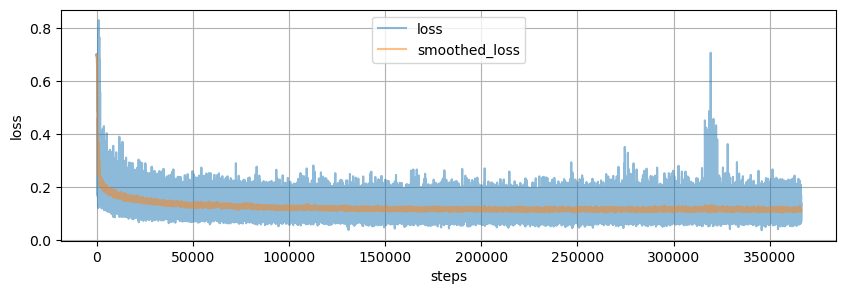

In [62]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss"); #plt.yscale('log');

In [63]:
targets2 = []
predictions2 = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    o = m2(x)

    for ti in t.detach().numpy():
        targets2.append(ti)
    for oi in o.detach().numpy():
        predictions2.append(oi)

targets2 = np.r_[targets2]
predictions2 = np.r_[predictions2]
targets2.shape, predictions2.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:14 Time:  0:00:140001


((58598, 26), (58598, 26))

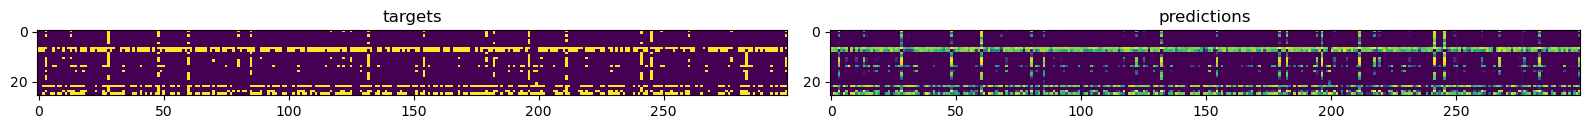

In [64]:
idxs = np.random.permutation(len(targets2))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets2[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions2[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")

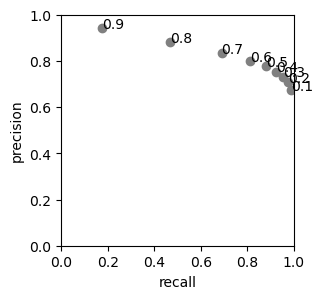

In [65]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets2.flatten(), predictions2.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [66]:
R2 = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets2[:,c], predictions2[:,c] >= thres) for c in range(targets2.shape[-1])]
    r = pd.DataFrame(r)
    R2.append(r)

R2 = np.array([r.values for r in R2])
R2.shape

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:330003


(100, 26, 2)

<Figure size 640x480 with 0 Axes>

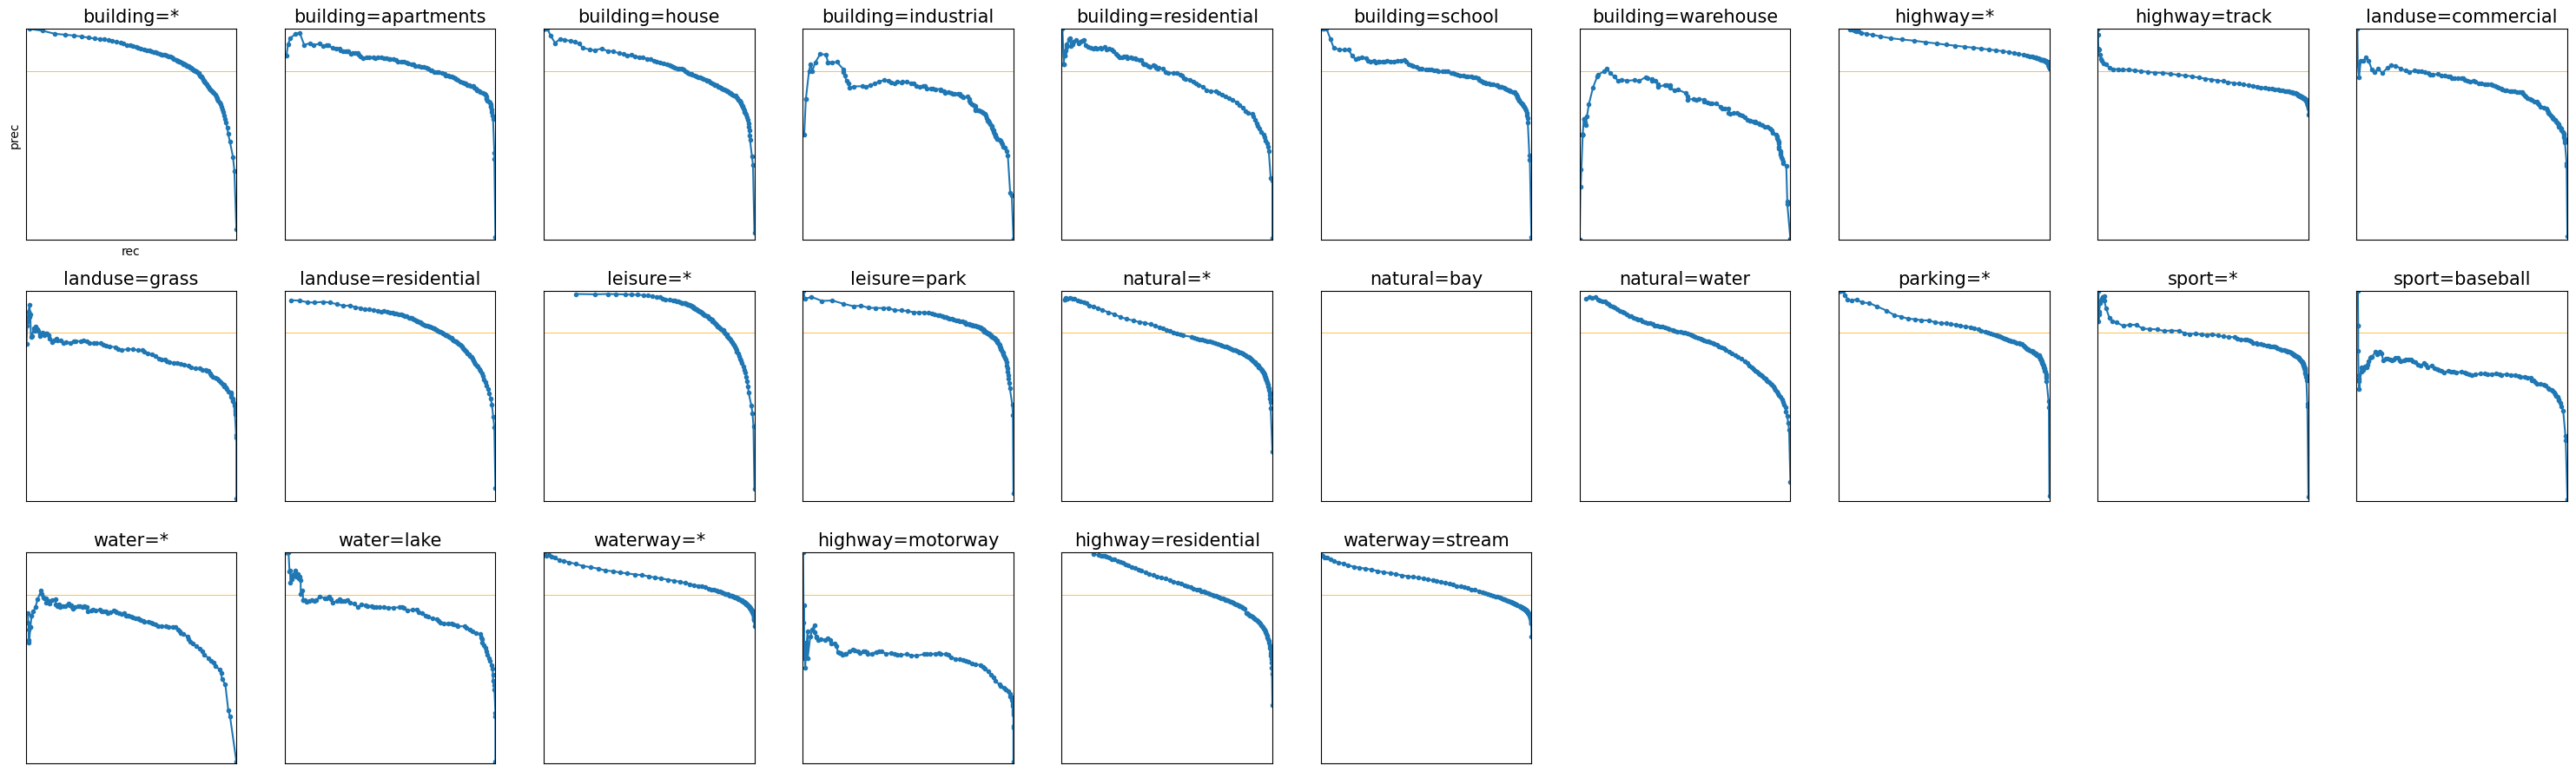

In [67]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R2[:, c, :].T, marker='o', ls='-', markersize=3);
plt.tight_layout();

---

prec >= .7, v0.2 embeddings
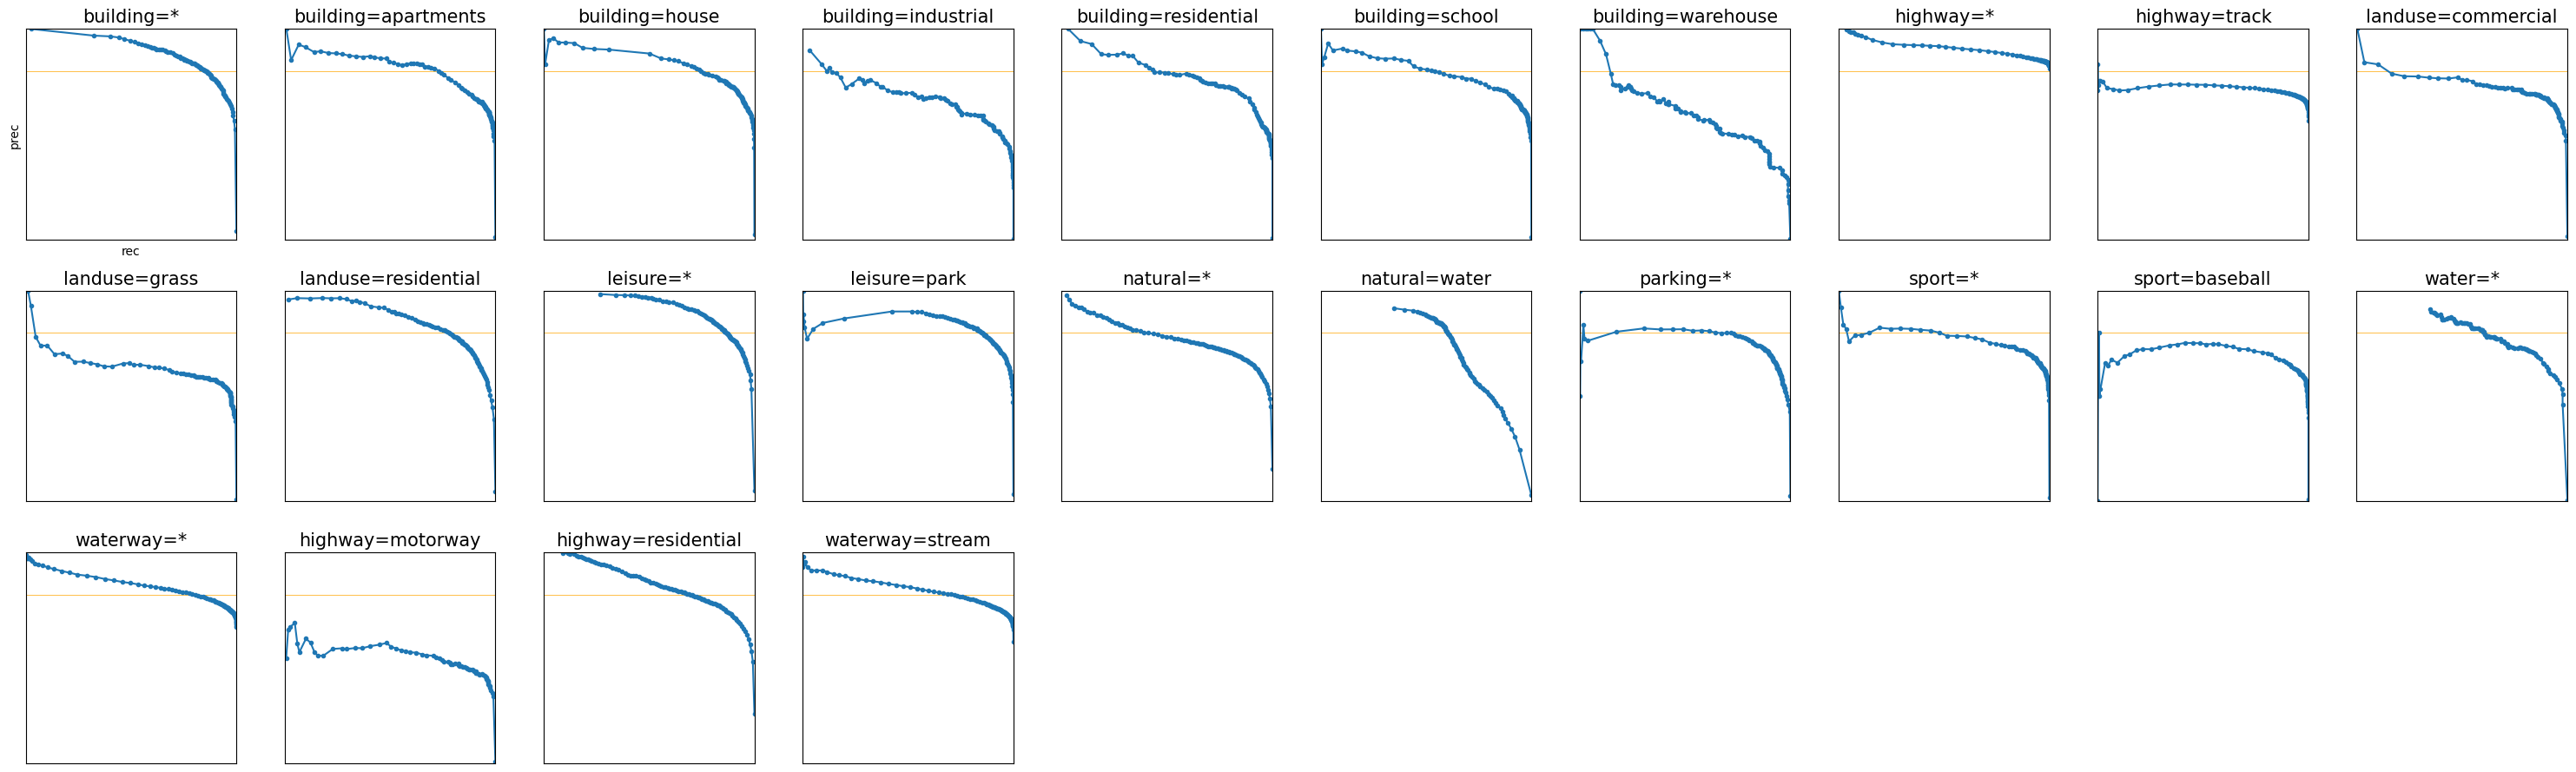

prec >= .7, v1.0 embeddings
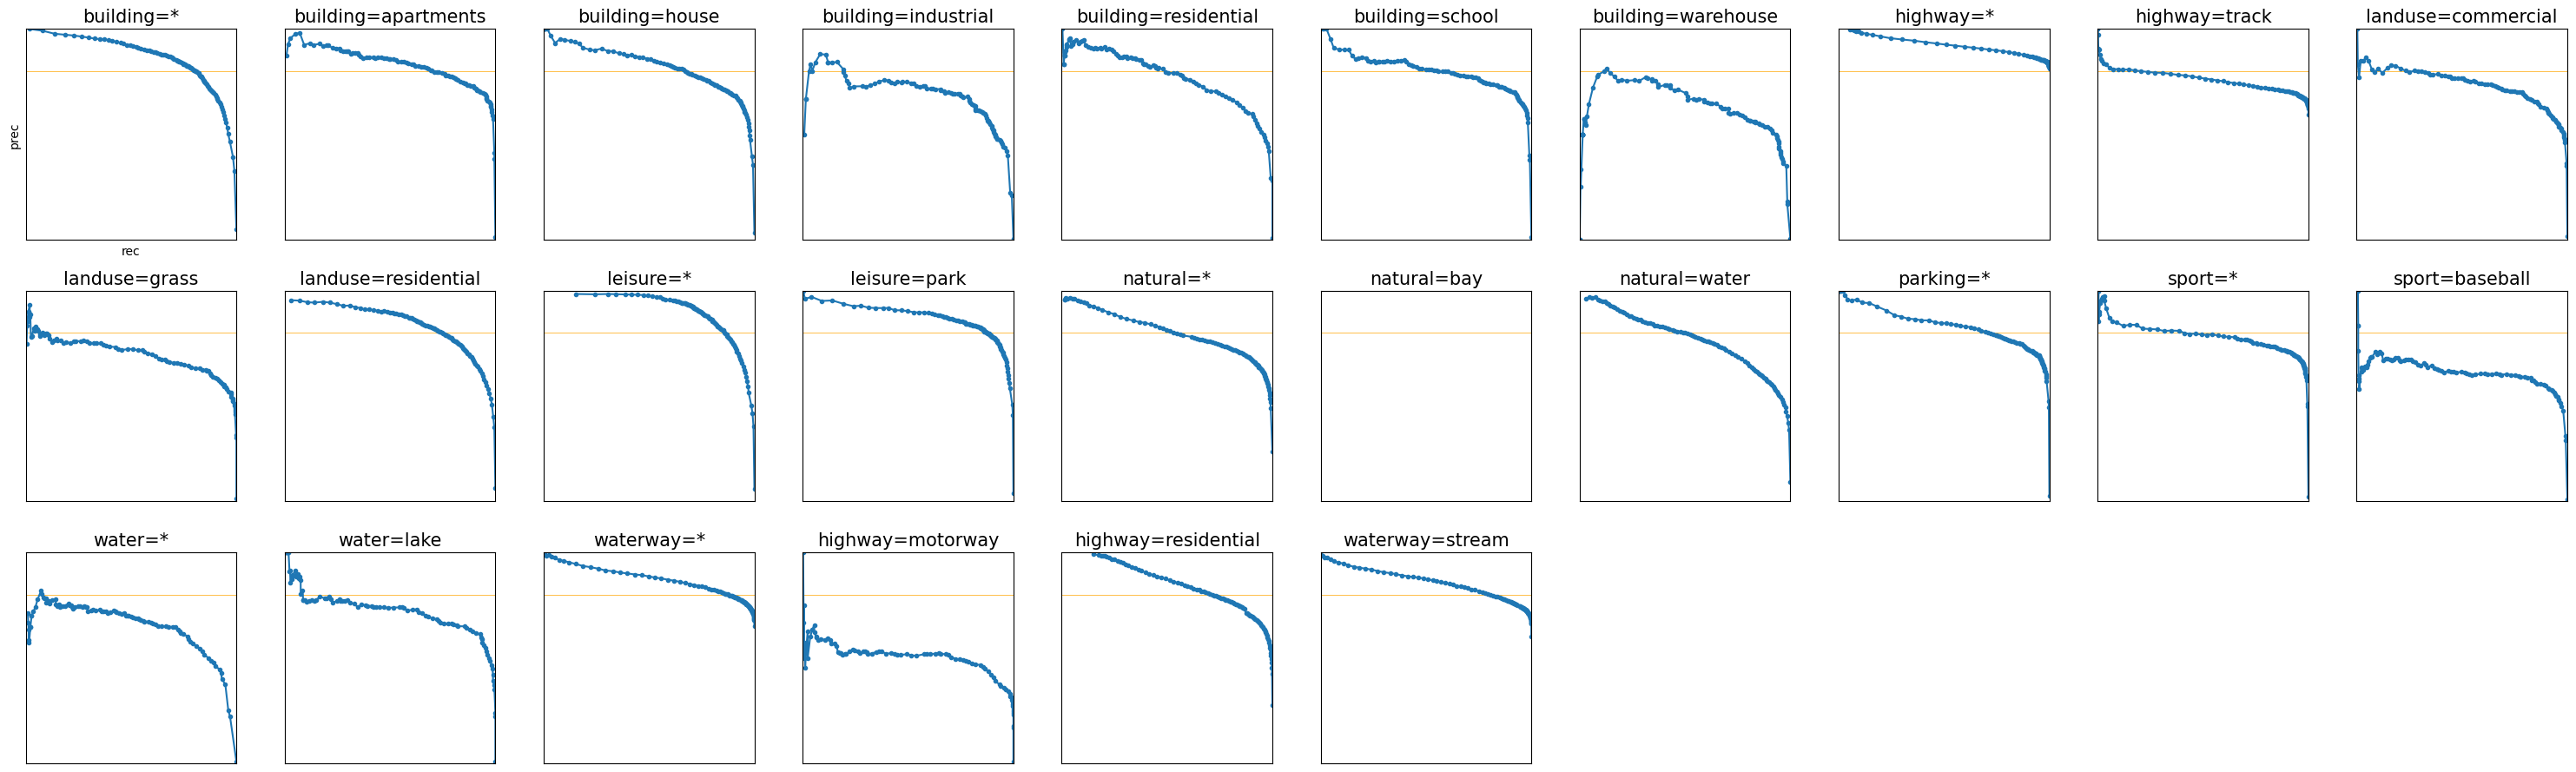

prec >= 0 (orig. labels), v1.0 embeddings
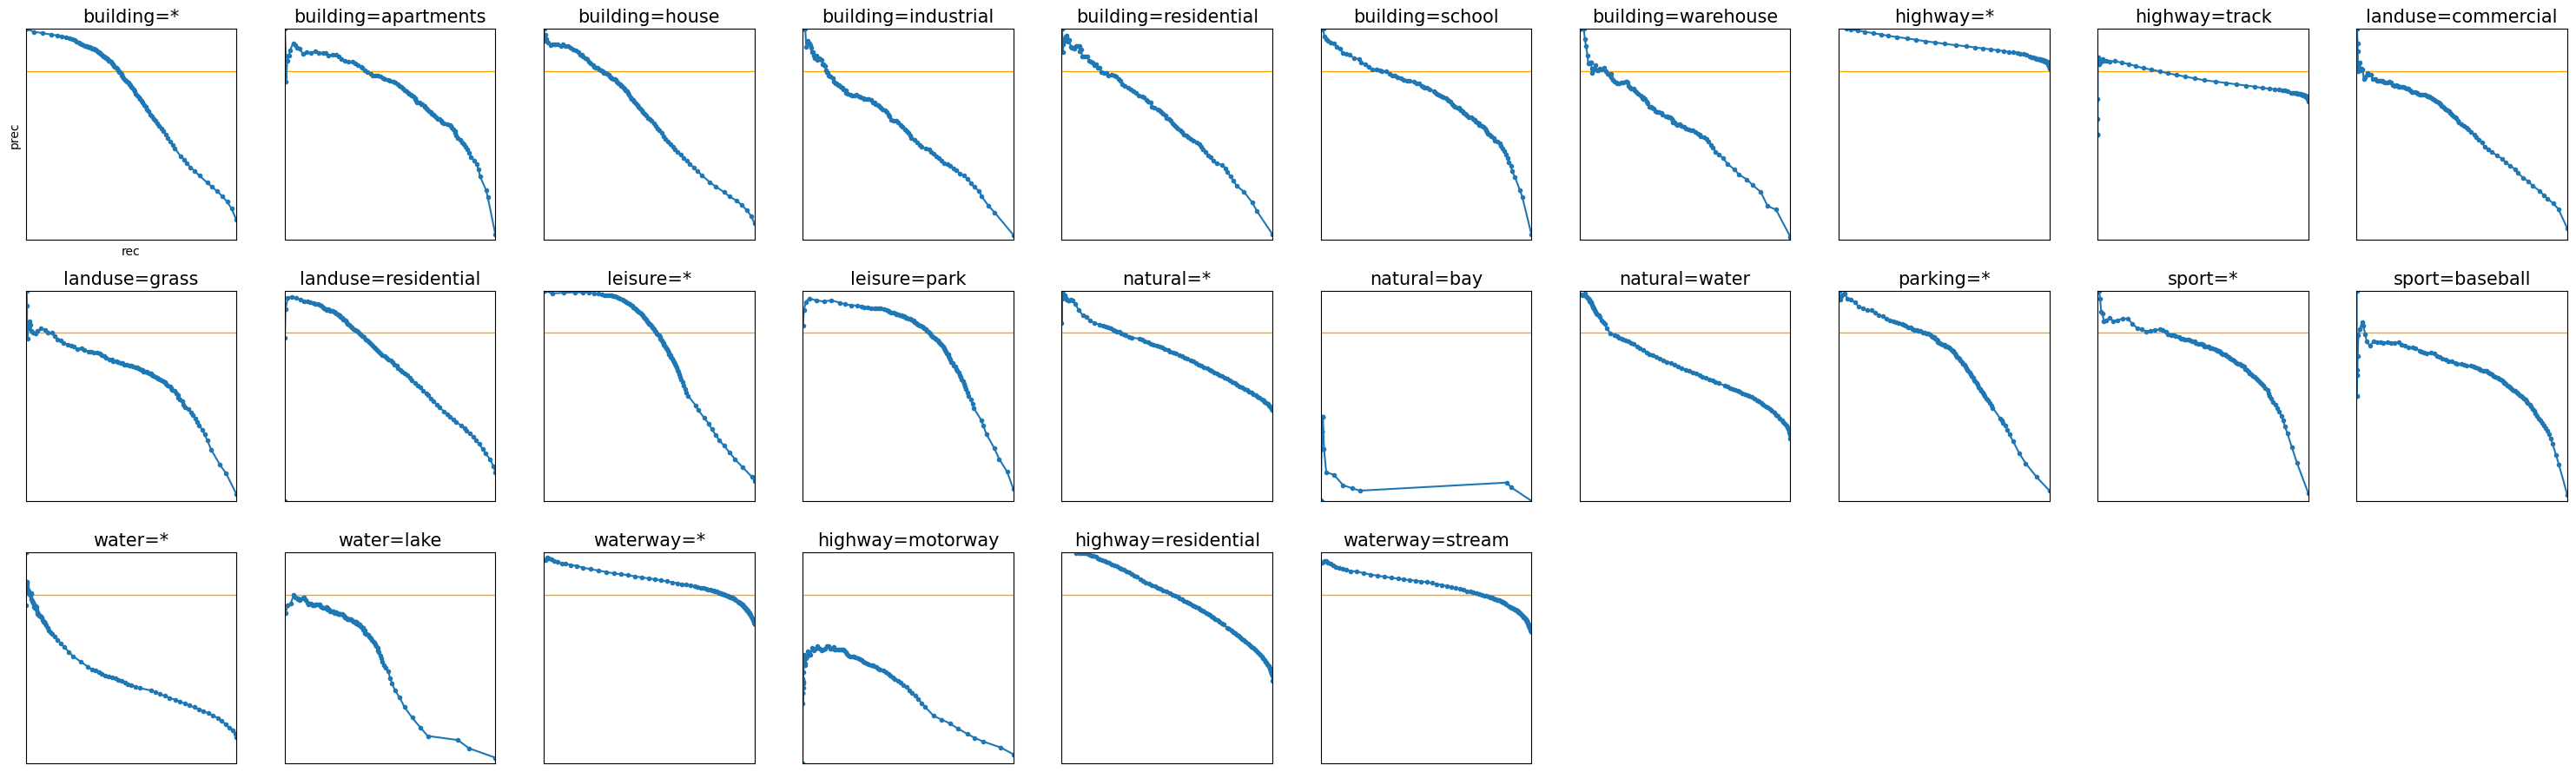


---

<Figure size 640x480 with 0 Axes>

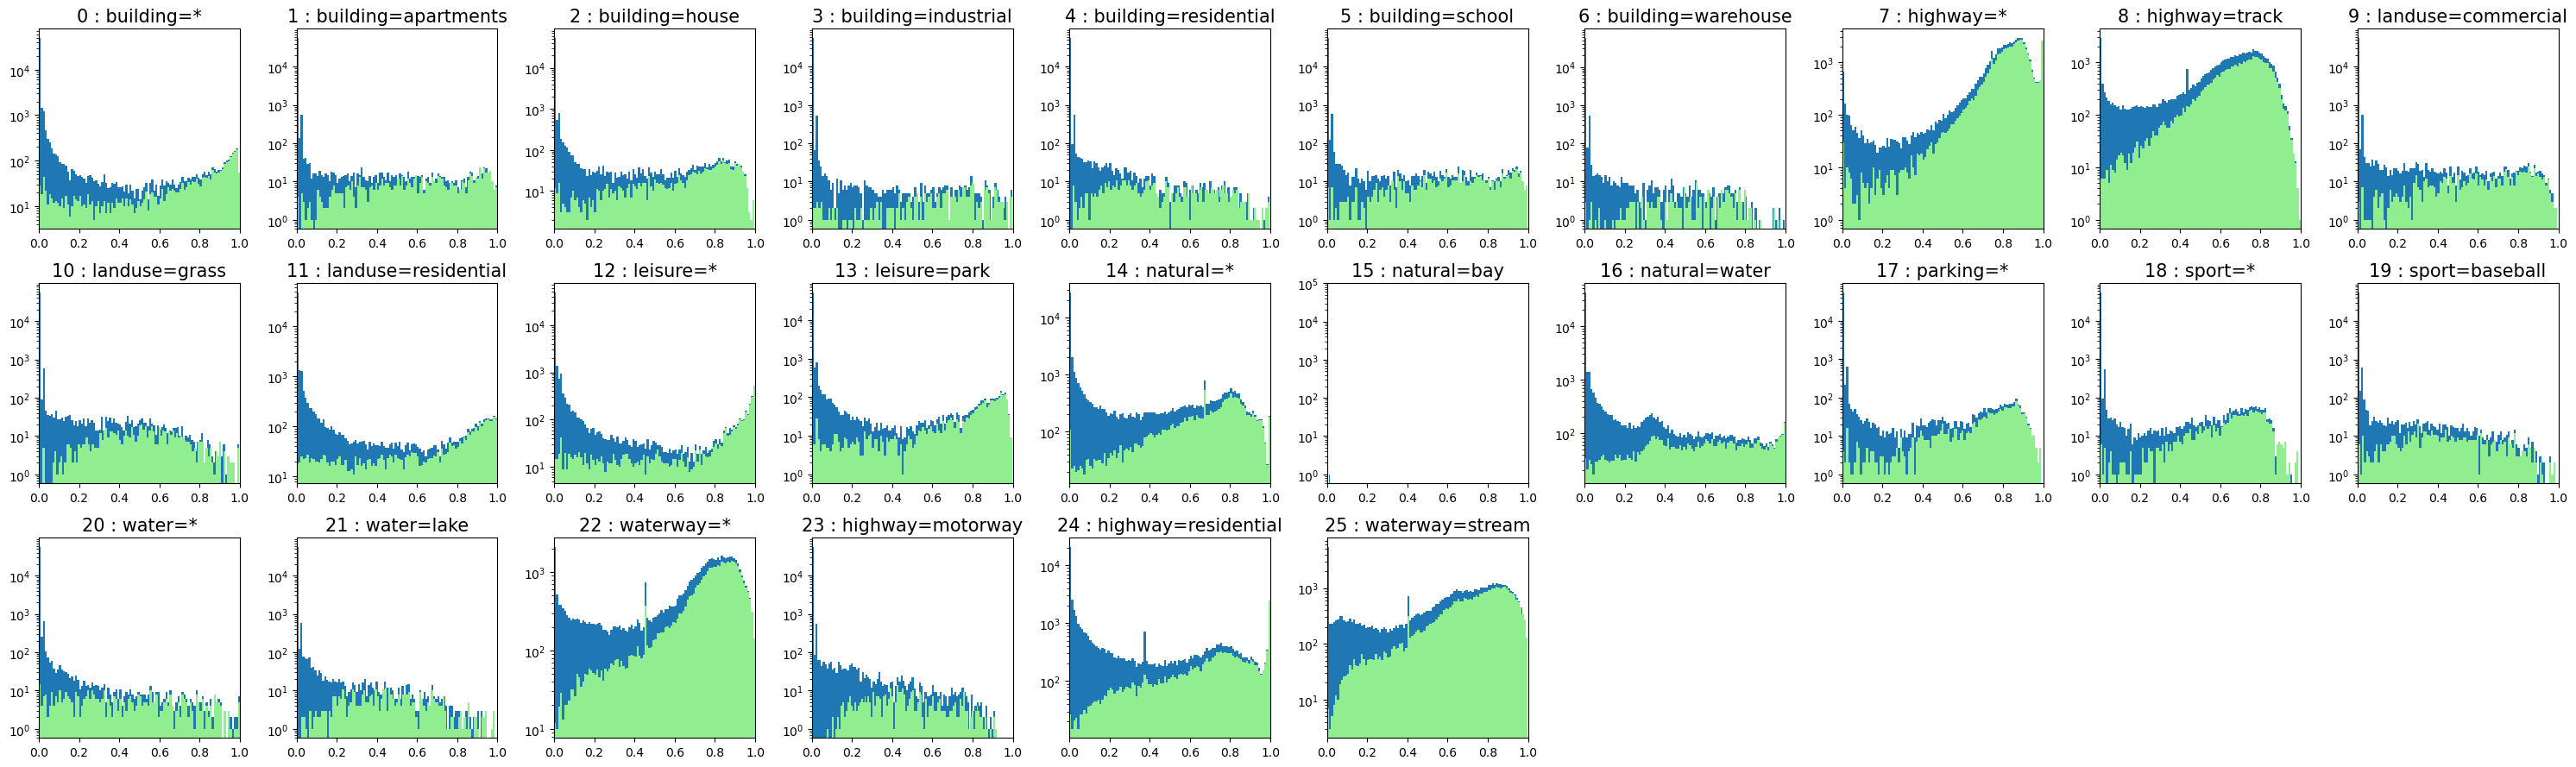

In [70]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions2[:, c], bins=100);
    plt.hist(predictions2[targets2[:, c] > 0, c], bins=100, color='lightgreen');
    # plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    # is_high_prec = (R[:, c, 1] >= .4)
    # if is_high_prec.sum() > 0:
    #     i_nz = is_high_prec.nonzero()[0][0]
    #     plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[classes_retain[c]]}", fontsize=15);